<img src="img/logo_wiwi_en_.png" width="30%" align="left">

<img src="img/decision_analytics_logo.png" width="17%" align="right">



<br><br><br><br><br><br><br><br>



# Combining OR and Data Science

**Summer Term 2023**


# 8. Algorithm Configuration


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer, Till Porrmann, Mohsen Nafar**

**Decision Analytics Group  | Bielefeld University**


In [1]:
# Import packages.
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mip import *

from mip.cbc import cbc_set_parameter

from IPython.display import display, HTML

import time

import pandas as pd



In [2]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 25px;
}
.dataframe td {
    font-size: 25px;
}
</style>

## Motivation: Consider a Race Car..

![race_car](img/race_car_parameter.jpg)

- a race car has lots of design parameters / settings to be decided upon
- there is not a single best car configuration
  - for each race track
  - for all weather conditions


## Tuning Algorithm Parameters

Like race cars, algorithms have many parameters that influence their performance:

![algo_config](img/parameters_algorithm.png)

- with good parameter settings, problems can be solved faster (or better)

## This Meeting: Algorithm Configuration


**In this meeting**, we deal with **algorithm configuration**

- understanding the relevance of algorithm configuration
- basic ideas and concepts
- introducing a case study
- automating algorithm configuration using black box (Bayesian) optimization
- addressing key challenges in algorithm configuration:
  - avoiding overfitting
  - reducing configuration time



## Case Study: Solving Chance-Constrained Programs Faster

- imagine a consulting project with a small belt manufacturing company where we
  want to use **joint chance constrained programming** (CCP) (see part 6 for the implementation)
- CCP models with binary variables can be very hard to solve 
- commercial solvers are very powerful, but only free for academic use
  - for small commercial projects, they tend to be too expensive:
     **a single Gurobi license is about $ 10 000**
- we will instead use the **open source** solver **CBC**

#### How can we improve CBC's performace?
- use algorithm configuration to improve CBC's performance for CCP models with 200 scenarios
- we would like to achieve a similar performance as Gurobi 
  - in my tests, Gurobi was about 3x as fast as CBC

## Case Study: Uncertain Availability of Time and Leather
- in the case study, we assume that both time and leather availability is uncertain 
- there is no possibility to resort to extra hours
- we want to find a production plan that is feasible with probability of 95\% 

We create 200 samples for both time and leather:

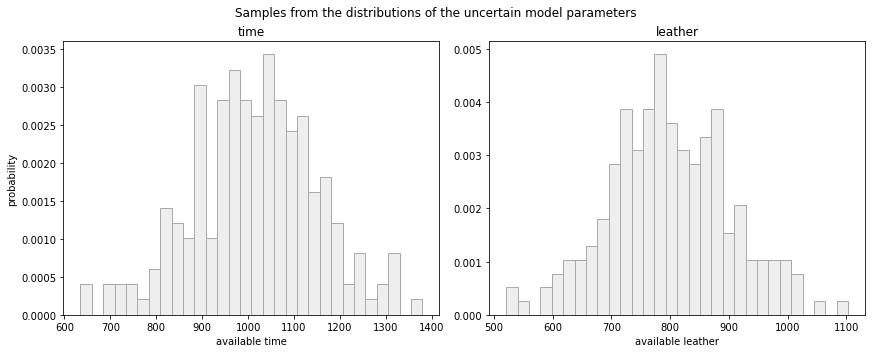

In [57]:
n_scenarios = 200

np.random.seed(seed=1)
time_available_dist = stats.norm(1000,150)
leather_available_dist = stats.norm(800,100)

samples_time_available = time_available_dist.rvs(n_scenarios)
samples_leather_available = leather_available_dist.rvs(n_scenarios)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(12, 4.8), constrained_layout=True)
fig.suptitle("Samples from the distributions of the uncertain model parameters")
ax1.set_ylabel("probability")


ax1.set_title("time")
count, bins, ignored = ax1.hist( samples_time_available , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
ax1.set_xlabel("available time")

ax2.set_title("leather")
count, bins, ignored = ax2.hist( samples_leather_available , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
ax2.set_xlabel("available leather")
plt.show()

## Case Study: Python Implementation of the Model Creation
Below, the creation of the mathematical is wrapped into a function that takes
- the time and leather samples
- and the solver 
as parameters



In [6]:
def build_model_with_samples(samples_time_available, samples_leather_available, solver):
    
    n_scenarios = len(samples_time_available)    
    scenarios = np.arange(n_scenarios)
    
    #sets
    belt_types = np.arange(2)

    #deterministic parameters
    profit_contribution = [2, 1.5]
    time_consumption = [2, 1]
    bucks_available = [400, 700]

    #probability of each scenario
    prob = np.full((n_scenarios), 1.0/n_scenarios)

    alpha = 0.95
    #bigM is used for switching off constraints by adding it to the resource capacity in a scenario
    #if it is chosen as difference between the max and min capacity, it is definitely large enough to switch off the constraint
    bigM = [max(samples_time_available)-min(samples_time_available),max(samples_leather_available)-min(samples_leather_available)]
        
    m = Model(solver_name=solver)  
    production = [ m.add_var(var_type=INTEGER) for i in belt_types ] # production variable 
    is_scenario_violated =  [ m.add_var(var_type=BINARY) for s in scenarios ] # binary variable indicating if scenario is vilated or not

    m.objective =  maximize( xsum(profit_contribution[b] * production[b] for b in belt_types) ) # objective function

    for s in scenarios:
        m += sum (time_consumption[b]*production[b] for b in belt_types) <= samples_time_available[s] + bigM[0]*(is_scenario_violated[s]) # chance constraint for time
        m += sum (production[b] for b in belt_types) <= samples_leather_available[s] + bigM[1]*(is_scenario_violated[s]) # chance constraint for leather
   
    m += sum ( prob[s]*is_scenario_violated[s] for s in scenarios) <= 1-alpha   # enforcing the maximium allowed violation probability

    return m

## Let us Try the Different Solvers
- CBC

In [11]:
model_instance_cbc = build_model_with_samples(samples_time_available, samples_leather_available, solver=CBC)

start = time.time()

model_instance_cbc.optimize()

print (f'Solution time with CBC: {time.time()-start:0.2f} seconds' )

Solution time with CBC: 1.06 seconds


- Gurobi

In [10]:
model_instance_gurobi = build_model_with_samples(samples_time_available, samples_leather_available, solver=GRB)

start = time.time()

model_instance_gurobi.optimize()

print (f'Solution time with Gurobi: {time.time()-start:0.2f} seconds' )


Solution time with Gurobi: 0.10 seconds


**Question: Can we tune the (free) solver CBC to become competitive with Gurobi for this problem?**

# Algorithm Configuration Basics

## What are Parameters?

Parameters are settings of an algorithm (or solver) that change the
way an algorithm solves a problem.


## What are Parameters?


Parameters are settings of an algorithm (or solver) that change the
way an algorithm solves a problem.

### There are configurable and non-configurable parameters



**Configurable**
- simulated annealing start temperature
- population size in a genetic algorithm (GA)
- branching heuristic in Branch-and-Bound 
- probability of a GA mutation

**Non-Configurable**
- random seed
- instance to be solved
- numerical accuracy in an exact solver
- maximum solution time


## Parameter Types


- Continuous: e.g. $[1.0, 5.0]$
- Discrete: e.g. $\{1, \dots, 10\}$
- Categorical: e.g. $\{a, b, c, d\}$
- Ordinal: e.g. $\{low, medium, high\}$ (Ordered set)



## Parameter Examples: Genetic Algorithm
A genetic algorithm could have the following parameters:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{cyan} {\textsf{ population }}$$ | Population size    | 1..infinity                      |
| $$\color{red} {\textsf{recombProb }}$$ | Recombination probability| 0-1.0                       |
| $$\color{red} {\textsf{mutProb }}$$    |  Mutation probability          | 0-1.0                |
| $$\color{green} {\textsf{select   }}$$    | Selection heuristic             | 'Roulette', 'Tournament', 'Random'       |
| $$\color{green}{\textsf{fitness-scaling  }}$$    | Use fitness scaling?     | 'yes', 'no'              |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## MIP Solver Parameters Used in our Case Study
In our case study, we will configure the MIP solver *CBC*
- CBC has many parameters, but we will only use a subset
- we will use the following parameters for configuration:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## Let us Start Playing with CBC Parameters in our Case Study

- first, we write a function for setting parameters


In [12]:
def set_cbc_parameter(model_instance, parameter, value):
    cbc_set_parameter(model_instance.solver,parameter,str(value)) # the function cbc_set parameter only takes string, we thus convert numbers to strings here
  

- now, we try out the parameter 'node_strategy' to 'depth'
- observe: we first make a copy to avoid that CBC uses a *warm start*, that is, starts from the previous state

In [18]:
model_instance_cbc = model_instance_cbc.copy() # reset the model to a fresh state (to avoid warm start!)

set_cbc_parameter(model_instance_cbc, 'node_strategy','fewest') # as an example, let us try depth-first-search

start = time.time()
model_instance_cbc.optimize()
print (f'Solution time: {time.time()-start:0.2f} seconds' )


Solution time: 1.02 seconds


## Making Experimentation Easier: An Evaluation Function

- we write a function that takes a model instance and a set of named parameter-value pairs
- and performs the complete evaluation based on a threshold of 30 seconds (returning the PAR10-performance, that is 10\*30 in case of timeout

In [19]:
def evaluate_parameters_on_instance(model_instance, **params):

    model = model_instance.copy() # we make a copy of the model here since    
    model.seed = 42 # set the seed to make multiple runs comparable
    
    for param, value in params.items(): # iterate over the names and values of the parameters
        cbc_set_parameter(model.solver,param,str(value)) # the function cbc_set parameter takes only strings
        
    time_limit_seconds = 30 
    start = time.time()    
    status = model.optimize(max_seconds=time_limit_seconds) # we set the runtime limit to 30
    
    if status == OptimizationStatus.OPTIMAL:    
        return (time.time()-start)    
    else: #  if the limit is exceeded, we return the time_limit *10, this is the PAR10 logic   
        return time_limit_seconds * 10

- let's see this in action:

In [20]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off', preprocess='off')
print (f'Solution time: {performance:0.2f} seconds' )
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off', 𝗌𝗍𝗋𝗈𝗇𝗀𝖡𝗋𝖺𝗇𝖼𝗁𝗂𝗇𝗀 =0.4, presolve='off', preprocess='off',𝗍𝗋𝗎𝗌𝗍𝖯𝗌𝖾𝗎𝖽𝗈𝖢𝗈𝗌𝗍𝗌=0)
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 0.99 seconds
Solution time: 0.91 seconds


## Exercise: Play with the Parameters!

Play with the following parameters! What is your best parameter combination?

| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

In [27]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off', preprocess='off',presolve='off', cutsOnOff='off')
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 0.33 seconds


## Why Bothering with Algorithm Configuration?

**Why would we care about algorithm configuration?**
- in many cases, algorithms are not only used once, but are part of a repeating planning workflow
  - e.g. monthly staff scheduling, daily power plant dispatch
- in these cases, the instance to solve are very similar
- sometimes, runtime is critical to allow testing multiple scenarios
- in many cases, configuration can lead to big runtime reductions
  - often, only a fraction (say, 1/10) of original runtime is needed
    after configuration
    

## Goals of Algorithm Configuration

There are two main types of algorithm configuration:

<div class="alert alert-block alert-info">
<b>Runtime configuration</b> <br> 
<li>Concerned with minimizing the runtime of a target algorithm.
</div>

<div class="alert alert-block alert-danger">
<b>Quality configuration</b> <br> 
<li>Concerned with minimizing an objective function seen only through the evaluation of an algorithm.
<li> This is generally the fitness/objective function of an optimization algorithm or the solution of a simulation.
</div>


## Offline Configuration and  Online Application


![off_on](img/algorithm_configuration_offline_online.png)




## Homogeneous vs Heterogeneous Instance Sets
#### Homogeneous datasets
*Homogeneous instance sets* contain instances with similar structures, allowing algorithms to use similar parameters on all of the instances to solve them.


#### Heterogeneous instance sets
*Heterogeneous instance sets* consist of two or more homogeneous sub-sets, but which instance belongs to which sub-aset is unclear. Different parameter values are required for different instances.

$\rightarrow$ This case may require a combination of algorithm selection (e.g. based on clustering) and algorithm configuration!


## Manual Configuration?

Can't we just **manually** tune parameters? 

We can, but it is
- time-consuming
- error-prone and 
- tedious

In [28]:
performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='off')
print (f'Solution time: {performance:0.2f} seconds' )

performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='hybrid', heuristicsOnOff='on')
print (f'Solution time: {performance:0.2f} seconds' )

performance = evaluate_parameters_on_instance(model_instance_cbc, nodeStrategy='fewest', heuristicsOnOff='on')
print (f'Solution time: {performance:0.2f} seconds' )

Solution time: 0.96 seconds
Solution time: 1.03 seconds
Solution time: 1.03 seconds


In many cases, it is more effective to **automate** algorithm
configuration!

# Automating the Configuration of Algorithms

##  Automating the Configuration of Algorithms

The goal of the following part is to get an introduction to the topic of
**algorithm configuration**

In particular,  will discuss
- the idea and the challenges of automatic algorithm configuration
- how to use black box (Bayesian) optimization for automatic algorithm configuration
- how to address the challenge of overfitting
- how to speed up algorithm selection by using early stopping

As in the last weeks, we will
- use a case study (see above) to illustrate the concepts learned
- provide implementations of an algorithm configuration approach for
  this case study in this Jupyter Notebook


## Automatic Algorithm Configuration: The Idea and the Challenges

## Automatic Algorithm Configuration

- automatic algorithm configurators **automatically** try different parameter settings on selected instances and measure the performance of the target algorithm. 
- they perform the search in a somewhat intelligent way

![off_on](img/automatic_algorithm_configuration.png)


## Challenges

#### Automated algorithm configurators have to overcome the following challenges (among many others):
- Which instances to evaluate parameterizations on
- Which parameterizations to test
- Testing parameterizations is **expensive**
- Big risk of overfitting

#### Why is algorithm configuration different from other optimization problems?
- The objective function in most metaheuristics is easy to evaluate (that is: fast)

-  Algorithm configurators must execute the target algorithm with a parameterization **on multiple instances** to evaluate it.

## Addressing the Challenges of Algorithm Configuration: Case Study


In the remainder of this meeting, we will see how we can address some of
the challenges fusing "standard" tools in our case study:



- using **Bayesian Optimization** to search the space of configurations
- optimize using **multiple training instances** to avoid overfitting
- use a simple **early stopping strategy** to reduce the time spent evaluating bad configurations


# Using Black Box (Bayesian) Optimization for Algorithm Configuration

## Black Box Optimization using Bayesian Optimization

A **black box optimizer** treats the optimization problem as "black box"
- it does not make any assumption regarding problem structure (e.g. linearity)
- it only requires a mechanism that returns the value of a solution / configuration

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-0.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-1.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-2.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-3.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-4.png)

Source: https://distill.pub/2020/bayesian-optimization/

## Illustrating Bayesian Optimization

**Key Idea of Bayesian Optimization**
- use a machine learning model (mostly: Gaussian Processes) as a
  surrogate model for the configuration space
- initialize the model using few (e.g. random) configurations
- update the surrogate model after each new evaluation

![BO](img/BO-5.png)
Source: https://distill.pub/2020/bayesian-optimization/

## Scikit-Optimize: A Package for Black Box Optimization

A **black box optimizer** treats the optimization problem as "black box"
- it does not make any assumption regarding problem structure (e.g. linearity)
- it only requires a mechanism that returns the value of a solution / configuration

**Scikit-Optimize**
- is a package for black box optimization with different methods, in particular:
  - Random Search 
  - **Bayesian Optimization**
- it can also be used for hyperparameter tuning of machine learning models

## Scikit-Optimize: A Package for Black Box Optimization

A **black box optimizer** treats the optimization problem as "black box"
- it does not make any assumption regarding problem structure (e.g. linearity)
- it only requires a mechanism that returns the value of a solution / configuration

**Scikit-Optimize**
- is a package for black box optimization with different methods, in particular:
  - random search 
  - **Bayesian Optimization**
- it can also be used for hyperparameter tuning of machine learning models


## Recall: MIP Solver Parameters Used in our Case Study
In our case study, we will configure the MIP solver *CBC*
- CBC has many parameters, but we will only use a subset
- we will use the following parameters for configuration:


| Parameter      | Description                               |Considered values    |
|:--------------------|:-------------------------------------------|:----------------------------|
| $$\color{green}{\textsf{nodeStrategy}}$$    | Strategy for selecting nodes to branch on   | 'depth', 'fewest','hybrid' |
| $$\color{cyan} {\textsf{ strongBranching }}$$ | # vars. to consider in strong branching     | 0-10                       |
| $$\color{cyan} {\textsf{trustPseudoCosts }}$$ | str. br. evals before trusting pseudo costs | 0-10                       |
| $$\color{green} {\textsf{preprocess }}$$    | Switch for model preprocessing              | 'on', 'off'                |
| $$\color{green} {\textsf{presolve   }}$$    | Switch for presolve reductions              | 'on', 'off','sos'          |
| $$\color{green}{\textsf{cutsOnOff   }}$$    | Switch for cut generation (all cuts)        | 'on', 'off'                |
| $$\color{green}{\textsf{ heuristicsOnOff }}$$ | Turn (all) heuristics on/off                | 'on', 'off'             |

$$\color{cyan}{\textsf{discrete }}, \color{red}{\textsf{continuous}}, \color{green}{\textsf{categorical}}$$

## Defining the Parameter Space and the Evaluation Function

- using data structures from `scikit-optimize`, we define the parameter space

In [33]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.space import Space

space  = [Categorical(['hybrid','fewest','depth'], name='nodeStrategy'),
          Integer(0,10,name='strongBranching'),
          Integer(0,10,name='trustPseudoCosts'),
          Categorical(['on','off'], name='preprocess'),
          Categorical(['on','off','sos'], name='presolve'),
          Categorical(['on','off'], name='cutsOnOff'),
          Categorical(['on','off'], name='heuristicsOnOff')]

- then, we define the objective / evaluation function. For now, we only use a single instance for evaluation

In [35]:
model_instance_for_objective = model_instance_cbc

@use_named_args(space)
def performance_objective_single_instance(**params):
    return evaluate_parameters_on_instance(model_instance_for_objective,**params)


## Running the Optimization
- let us now run the optimization
- note that by using the parameter `n_calls`, we limit the number of configurations evaluated to 50

In [36]:
from skopt import gp_minimize

results_single_instance = gp_minimize(performance_objective_single_instance, space, verbose=True, n_calls=50, random_state=0)

print(f"Best configuration: {results_single_instance.x}")
print(f"Best performance in seconds: {results_single_instance.fun:0.2f}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4809
Function value obtained: 0.4653
Current minimum: 0.4653
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5481
Function value obtained: 0.5481
Current minimum: 0.4653
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9962
Function value obtained: 0.9806
Current minimum: 0.4653
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1965
Function value obtained: 1.1865
Current minimum: 0.4653
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2811
Function value obtained: 0.2731
Current minimum: 0.2731
Iteration No: 6 started. Evaluating

C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.0201
Function value obtained: 0.2421
Current minimum: 0.2092
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.9772
Function value obtained: 0.3434
Current minimum: 0.2092
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8205
Function value obtained: 0.2812
Current minimum: 0.2092
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.1915
Function value obtained: 0.4630
Current minimum: 0.2092
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.0549
Function value obtained: 0.3515
Current minimum: 0.2092
Iteration No: 27 started. Sea

C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8291
Function value obtained: 0.2297
Current minimum: 0.2092
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.9384
Function value obtained: 0.2467
Current minimum: 0.2092
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.3064
Function value obtained: 0.6217
Current minimum: 0.2092
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.6025
Function value obtained: 0.9738
Current minimum: 0.2092
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.6297
Function value obtained: 2.9069
Current minimum: 0.2092
Iteration No: 34 started. Sea

C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.0670
Function value obtained: 0.3070
Current minimum: 0.2092
Iteration No: 39 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.0264
Function value obtained: 0.2757
Current minimum: 0.2092
Iteration No: 40 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.0693
Function value obtained: 0.2913
Current minimum: 0.2092
Iteration No: 41 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.2076
Function value obtained: 0.3077
Current minimum: 0.2092
Iteration No: 42 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.1374
Function value obtained: 0.2865
Current minimum: 0.2092
Iteration No: 43 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2246
Function value obtained: 0.3121
Current minimum: 0.2092
Iteration No: 44 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.1625
Function value obtained: 0.2937
Current minimum: 0.2092
Iteration No: 45 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.2098
Function value obtained: 0.2968
Current minimum: 0.2092
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.1608
Function value obtained: 0.3208
Current minimum: 0.2092
Iteration No: 47 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.1174
Function value obtained: 0.3012
Current minimum: 0.2092
Iteration No: 48 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.1906
Function value obtained: 0.2928
Current minimum: 0.2092
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.2261
Function value obtained: 0.3158
Current minimum: 0.2092
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.1261
Function value obtained: 0.2918
Current minimum: 0.2092
Best configuration: ['depth', 4, 0, 'on', 'off', 'off', 'off']
Best performance in seconds: 0.21


- let's perform some pretty-printing of the best solution:

In [42]:
def print_best_solution(result_object):
    df = pd.DataFrame([result_object.x])
    df.columns = Space(space).dimension_names
    df["seconds"]=(result_object.fun)
    display(HTML(df.to_html(index=False)))
    
print_best_solution(results_single_instance)

results_single_instance.x

nodeStrategy,strongBranching,trustPseudoCosts,preprocess,presolve,cutsOnOff,heuristicsOnOff,seconds
depth,4,0,on,off,off,off,0.209211


['depth', 4, 0, 'on', 'off', 'off', 'off']

## Showing all Evaluations

- it may also be interesting to see all evaluations

In [38]:
def all_evaluations_as_df(result_object):
    df = pd.DataFrame(result_object.x_iters)
    df.columns = Space(space).dimension_names
    df["time"]=(result_object.func_vals)
    return df
df_evaluations = all_evaluations_as_df(results_single_instance)
df_evaluations.head()

,nodeStrategy,strongBranching,trustPseudoCosts,preprocess,presolve,cutsOnOff,heuristicsOnOff,time
0,fewest,8,9,on,on,off,off,0.465286
1,depth,3,5,on,on,off,on,0.548123
2,fewest,6,4,on,off,on,off,0.980581
3,hybrid,5,7,on,on,on,on,1.186462
4,depth,5,2,on,off,off,off,0.273064


- we can then even filter these results, e.g. to show all runs taking less than one second:

In [40]:
df_evaluations[df_evaluations["time"] <= 0.25]

,nodeStrategy,strongBranching,trustPseudoCosts,preprocess,presolve,cutsOnOff,heuristicsOnOff,time
12,depth,3,1,on,off,off,off,0.234858
14,hybrid,10,2,off,sos,off,off,0.249524
20,depth,4,0,on,off,off,off,0.209211
21,depth,4,0,on,off,off,off,0.242115
27,hybrid,4,0,on,sos,off,off,0.209384
28,hybrid,4,0,on,sos,off,off,0.229734
29,hybrid,4,1,on,sos,off,off,0.246684


# Avoiding Overfitting

## Avoiding Overfitting

- even in case of homogeneous instances, algorithm configuration is
  very prone to overfitting


- in general, in machine learning, we would use cross validation for addressing overfitting
- in algorithm configuration, however, **cross validation is not
  practical** since it requires too many time-consuming evaluations
- thus, in algorithm configuration one mostly uses 
  - a single training set
  - and a single test set


## Evaluating the Configuration on a Test Set

Let us see how our configuration (selected for a single instance) performs on average for a test set of 10 instances

**Question:**
- How can we create a test set (a set of test instances) for our CCP case study?


In [62]:
np.random.seed(seed=11)

number_of_test_instances = 10
test_instances =  []

for i in range(number_of_test_instances):
    samples_time_available = time_available_dist.rvs(n_scenarios)
    samples_leather_available = leather_available_dist.rvs(n_scenarios)
    test_instances.append(build_model_with_samples(samples_time_available, samples_leather_available, CBC))

- then, we define an evaluation function for evaluating a configuration on multiple instances:

In [63]:
def evaluate_parameters_on_instances(instances, **params):
    total_time = 0
    
    number_of_instances = len(instances)    
    for instance in instances:
        total_time += evaluate_parameters_on_instance(instance, **params)
        
    return total_time / number_of_instances

- and another function that directly takes the skopt solution and applies it to a set of instances:

In [64]:
def evaluate_skopt_parameters_on_instances(instances, sk_opt_solution):    
    param_dict = dict(zip(Space(space).dimension_names, sk_opt_solution))
    return evaluate_parameters_on_instances(test_instances, **param_dict)                                            

**Exercise:**
- Create a test set consisting of 10 model instances (based on 10 different sets of samples for time and leather availability)
- Write an function for evaluating a configuration on multiple instances (using average runtime as result measure)
- Evaluate the best configuration found above using that function and compare the result to the single-instance evaluation used for configuration!

**Hint:** See the following function for how to evaluate an sk_opt solution on a single instance!

In [53]:
def evaluate_skopt_parameters_on_instance(instance, sk_opt_solution):    
    param_dict = dict(zip(Space(space).dimension_names, sk_opt_solution))
    return evaluate_parameters_on_instance(instance, **param_dict)    

evaluate_skopt_parameters_on_instance(model_instance_cbc, results_single_instance.x)

0.19094014167785645

In [ ]:
def evaluate_skopt_parameters_on_instances(instances, sk_opt_solution):
    

## Evaluating the Configuration on a Test Set: Results

Let's create a data frame to collect the results

In [65]:
df_results = pd.DataFrame(columns=['train_perf','test_perf'])

- we start with an evaluation of the CBC standard settings:

In [66]:
df_results.loc['Standard CBC','test_perf'] = evaluate_parameters_on_instances(test_instances)

- and then add those from training with a single instance (note: train performance is based on a single instance, test performance is evaluated using 10 instances

In [67]:
df_results.loc['Configured Single Instance','train_perf'] = results_single_instance.fun

df_results.loc['Configured Single Instance','test_perf']=  evaluate_skopt_parameters_on_instances(test_instances,results_single_instance.x )

In [68]:
df_results

,train_perf,test_perf
Standard CBC,NaN,1.134845
Configured Single Instance,0.209211,0.2903


## Addressing Overfitting: Configuration using Multiple Training Instances

Let us see if we can do better by evaluating each configuration on multiple instances **during training**!

- we thus create 10 training instances:



In [69]:

np.random.seed(seed=42)
number_of_training_instances = 10
training_instances = []
for i in range(number_of_training_instances):
    time_available = time_available_dist.rvs(n_scenarios)
    leather_available = leather_available_dist.rvs(n_scenarios)
    
    training_instances.append( build_model_with_samples(time_available, leather_available, CBC) )   

- then, we create an objective function for scikit-optimize that uses these 10 instances:
    

In [70]:
instances_to_evaluate = training_instances  
@use_named_args(space)
def evaluate_parameters_on_multiple_instances(**params):
    return evaluate_parameters_on_instances(instances_to_evaluate,**params)

## Automatic Configuration Using Multiple Instances

In [71]:
start_time_configuration_multiple_instances = time.time()

results_multiple_instances = gp_minimize(evaluate_parameters_on_multiple_instances, space, verbose=True, n_calls=50, random_state=0)

duration_configuration_multiple_instances = time.time() - start_time_configuration_multiple_instances

print (f"The configuration took {duration_configuration_multiple_instances:0.2f} seconds")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9623
Function value obtained: 0.3859
Current minimum: 0.3859
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.1830
Function value obtained: 1.1091
Current minimum: 0.3859
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.4714
Function value obtained: 1.0360
Current minimum: 0.3859
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.7698
Function value obtained: 1.3700
Current minimum: 0.3859
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.0848
Function value obtained: 0.2966
Current minimum: 0.2966
Iteration No: 6 started. Evaluat

C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.6118
Function value obtained: 0.2995
Current minimum: 0.2868
Iteration No: 24 started. Searching for the next optimal point.


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.6581
Function value obtained: 0.3037
Current minimum: 0.2868
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.5108
Function value obtained: 0.2893
Current minimum: 0.2868
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.6714
Function value obtained: 0.3063
Current minimum: 0.2868
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 99.1752
Function value obtained: 90.7967
Current minimum: 0.2868
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.7065
Function value obtained: 0.3030
Current minimum: 0.2868
Iteration No: 29 started. S

## Automatic Configuration Using Multiple Instances: Results

How did it work?

In [73]:
df_results.loc['Configured Multiple Instances','train_perf'] = results_multiple_instances.fun

df_results.loc['Configured Multiple Instances','test_perf']=  evaluate_skopt_parameters_on_instances(test_instances,results_multiple_instances.x )

df_results

,train_perf,test_perf
Standard CBC,NaN,1.134845
Configured Single Instance,0.209211,0.2903
Configured Multiple Instances,0.28683,0.249643


- it worked better, that is, using multiple training instances is advantageous.

# Making Algorithm Configuration Faster: Early Stopping

## Making Configuration Faster: Early Stopping

**Challenge: Long Configuration Time**

**Long configuration times**
- using multiple training instances will improve the robustness of the results, 
- but it will also drastically increase configuration time


**Question:** Do you have any idea how to reduce configuration time?


**We can reduce configuration time by**
- quickly recognizing bad configurations and evaluating them on only a
  few instances
- we may even use statistical tests to detect bad configurations early
- in our case study, we will use a simple early stopping approach

## A Simple Early Stopping Approach for our Case Study


**Goal:** 

Detect "bad" configs early and stop their
evaluation after few instances


**Assumption:**
- we have a *very homogeneous* set of instances
- the run times of the instances are relatively similar

**Evaluation of a configuration $c$ with early stopping:**

Let $g(i)$ be a factor $\geq 1$ that decreases with an increasing instance index $i$

and  $f^*$ be the current best average performance 


For the set of instances from $i=1$ to $n$:
- evaluate the performance $f_c(i)$ of configuration 
- update the average performance $\hat{f}_c$ with $f_c(i)$
- if $\hat{f}_c > g(i)f^*$, stop early and return $\hat{f}_c$

return $\hat{f}_c$


**Intuitive rationale of using the decreasing factor g(i)**
- at the beginning, the "bar" should be higher in order to stop evaluation based on one or two underperforming runs (bad luck)



##  Implementing the Early Stopping Approach

**Scikit-Optimize's "ask-and-tell" interface**
allows to interact with the Optimizer solver via two functions:
- **Ask** (the optimizer) for the next configuration to evaluate
- **Tell** the objective function value to the optimizer
$\rightarrow$ This gives us control on how to compute the objective value


**For our purposes, we use it as follows:**

For a given number of iterations:
- **Ask** the optimizer for the next configuration
- perform the evaluation of the configuration
  - in our case, using the early-stopping mechanism
- **Tell** the optimizer the performance of the configuration


##  The Implementation of the Early Stopping Approach

- first we write a function returning the exceedance factor $g(i)$ based on the total number of instances and the number of instances evaluated so far ($i$)
- this implementation of the function is pretty simple, the key idea is that the factor decreases with the number of instances evaluated so far

In [74]:
def get_exceedance_factor (total_number_of_instances, number_of_instances_evaluated_so_far):
    if number_of_instances_evaluated_so_far <= 1:
        return 1000
    
    fraction_instances_remaining = (total_number_of_instances - number_of_instances_evaluated_so_far) / total_number_of_instances
    return 1.1 + fraction_instances_remaining * 0.5

#example
get_exceedance_factor(10,8)


1.2000000000000002

- then, we write a function that uses the early stopping idea for evaluation

In [75]:
def evaluate_with_early_stopping(instances, best_performance, sk_opt_params):
    evaluated_instances = 0    
    total_performance  = 0
    
    total_number_of_instances = len(instances)    
    for instance in instances:
        evaluated_instances  += 1
        param_dict = dict(zip(Space(space).dimension_names, sk_opt_params))
        total_performance += evaluate_parameters_on_instance(instance, **param_dict)        
        average_performance = total_performance / evaluated_instances        
        # early stopping condition.
        if average_performance >  best_performance * get_exceedance_factor(total_number_of_instances, evaluated_instances):
            print(f" Stopping early after { evaluated_instances } instances")
            return average_performance        
    return average_performance    

##  Running the Algorithm Configuration with the Early Stopping Approach

- now, we run the early stopping-based algorithm configuration 
- the following implementation uses the sickit-optimizes ask-and-tell interface explained above

In [76]:
from skopt import Optimizer

# let us take the standard configuration as best-known configuration in the beginning
best_performance = evaluate_parameters_on_instances(training_instances)

number_of_total_iterations = 50

opt = Optimizer(space, random_state=0)
start_time_early_stopping = time.time()
for n in range(number_of_total_iterations):

    next_params = opt.ask() # ask the optizer for the next configuration
    
    # call the early stopping evaluation
    performance = evaluate_with_early_stopping(training_instances, best_performance, next_params)
    
    print (f"Iteration {n}: performance: {performance:0.2f}")
    
    if performance < best_performance:
        best_performance = performance
    
    print (f" After Iteration {n}: best performance: {best_performance:0.2f}\n")
    
    results_early_stopping = opt.tell(next_params, performance)  # tell the optizer the performance of the evaulation
    
duration_early_stopping = time.time() - start_time_early_stopping
print (f"The configuration using early stopping took {duration_early_stopping:0.2f} seconds")
print_best_solution(results_early_stopping)

Iteration 0: performance: 0.40
 After Iteration 0: best performance: 0.40

 Stopping early after 2 instances
Iteration 1: performance: 0.72
 After Iteration 1: best performance: 0.40

 Stopping early after 2 instances
Iteration 2: performance: 1.16
 After Iteration 2: best performance: 0.40

 Stopping early after 2 instances
Iteration 3: performance: 1.28
 After Iteration 3: best performance: 0.40

Iteration 4: performance: 0.29
 After Iteration 4: best performance: 0.29

 Stopping early after 2 instances
Iteration 5: performance: 1.40
 After Iteration 5: best performance: 0.29

 Stopping early after 2 instances
Iteration 6: performance: 1.37
 After Iteration 6: best performance: 0.29

 Stopping early after 2 instances
Iteration 7: performance: 1.37
 After Iteration 7: best performance: 0.29

 Stopping early after 2 instances
Iteration 8: performance: 1.04
 After Iteration 8: best performance: 0.29

 Stopping early after 2 instances
Iteration 9: performance: 1.18
 After Iteration 9: be

C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


 Stopping early after 2 instances
Iteration 11: performance: 1.20
 After Iteration 11: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


 Stopping early after 2 instances
Iteration 12: performance: 1.20
 After Iteration 12: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


 Stopping early after 2 instances
Iteration 13: performance: 1.19
 After Iteration 13: best performance: 0.29

 Stopping early after 3 instances
Iteration 14: performance: 0.45
 After Iteration 14: best performance: 0.29

 Stopping early after 1 instances
Iteration 15: performance: 300.00
 After Iteration 15: best performance: 0.29

 Stopping early after 2 instances
Iteration 16: performance: 0.73
 After Iteration 16: best performance: 0.29

 Stopping early after 2 instances
Iteration 17: performance: 0.58
 After Iteration 17: best performance: 0.29

 Stopping early after 2 instances
Iteration 18: performance: 0.79
 After Iteration 18: best performance: 0.29

 Stopping early after 2 instances
Iteration 19: performance: 0.97
 After Iteration 19: best performance: 0.29

 Stopping early after 2 instances
Iteration 20: performance: 1.36
 After Iteration 20: best performance: 0.29

 Stopping early after 2 instances
Iteration 21: performance: 1.07
 After Iteration 21: best performance: 0.29


C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 36: performance: 0.30
 After Iteration 36: best performance: 0.29

 Stopping early after 10 instances
Iteration 37: performance: 0.32
 After Iteration 37: best performance: 0.29

Iteration 38: performance: 0.30
 After Iteration 38: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 39: performance: 0.31
 After Iteration 39: best performance: 0.29

 Stopping early after 7 instances
Iteration 40: performance: 0.45
 After Iteration 40: best performance: 0.29

 Stopping early after 2 instances
Iteration 41: performance: 0.54
 After Iteration 41: best performance: 0.29

 Stopping early after 7 instances
Iteration 42: performance: 0.45
 After Iteration 42: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 43: performance: 0.31
 After Iteration 43: best performance: 0.29

 Stopping early after 10 instances
Iteration 44: performance: 0.34
 After Iteration 44: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 45: performance: 0.29
 After Iteration 45: best performance: 0.29

 Stopping early after 7 instances
Iteration 46: performance: 0.37
 After Iteration 46: best performance: 0.29

 Stopping early after 8 instances
Iteration 47: performance: 0.35
 After Iteration 47: best performance: 0.29

Iteration 48: performance: 0.29
 After Iteration 48: best performance: 0.29



C:\Users\mroemer\Miniconda3\envs\cords2022\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 49: performance: 0.29
 After Iteration 49: best performance: 0.29

The configuration using early stopping took 202.70 seconds


nodeStrategy,strongBranching,trustPseudoCosts,preprocess,presolve,cutsOnOff,heuristicsOnOff,seconds
fewest,4,2,on,on,off,off,0.291409


## Let us see the results

- let's add the results from the early stopping approach

In [79]:
#add to results
df_results.loc['Configured Multi Instance Early Stop','train_perf'] = results_early_stopping.fun

df_results.loc['Configured Multi Instance Early Stop','test_perf']=  evaluate_skopt_parameters_on_instances(test_instances,results_early_stopping.x )

In [80]:
df_results

,train_perf,test_perf
Standard CBC,NaN,1.134845
Configured Single Instance,0.209211,0.2903
Configured Multiple Instances,0.28683,0.249643
Configured Multi Instance Early Stop,0.291409,0.289511


..we can see that the early stopping was much faster, but we obtained similar (even better) results.

## Conclusions

**In this meeting, we dealt with algorithm configuration**
- we learned about the key concepts of algorithm configuration
- and learned how to address the key challenges in automatic algorithm configuration

**This was the last meeting of our course!**
- thank you very much for your active participation!